Code in the cell below uses shell commands to download data files from GitHub into the Databricks File System (DBFS) used by your cluster

In [0]:
 %sh
 rm -r /dbfs/spark_lab
 mkdir /dbfs/spark_lab
 wget -O /dbfs/spark_lab/2019.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2019.csv
 wget -O /dbfs/spark_lab/2020.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2020.csv
 wget -O /dbfs/spark_lab/2021.csv https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2021.csv


rm: cannot remove '/dbfs/spark_lab': No such file or directory
--2024-03-12 11:37:42--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122681 (120K) [text/plain]
Saving to: ‘/dbfs/spark_lab/2019.csv’

     0K .......... .......... .......... .......... .......... 41%  706K 0s
    50K .......... .......... .......... .......... .......... 83%  966K 0s
   100K .......... .........                                  100% 6.69M=0.1s

2024-03-12 11:37:43 (955 KB/s) - ‘/dbfs/spark_lab/2019.csv’ saved [122681/122681]

--2024-03-12 11:37:43--  https://raw.githubusercontent.com/MicrosoftLearning/mslearn-databricks/main/data/2020.csv
Resolving raw.githubusercontent.com (raw.github

In [0]:
df = spark.read.load('spark_lab/*.csv', format='csv')
display(df.limit(5))

_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8
SO49171,1,2021-01-01,Mariah Foster,mariah21@adventure-works.com,"Road-250 Black, 48",1,2181.5625,174.525
SO49172,1,2021-01-01,Brian Howard,brian23@adventure-works.com,"Road-250 Red, 44",1,2443.35,195.468
SO49173,1,2021-01-01,Linda Alvarez,linda19@adventure-works.com,"Mountain-200 Silver, 38",1,2071.4196,165.7136
SO49174,1,2021-01-01,Gina Hernandez,gina4@adventure-works.com,"Mountain-200 Silver, 42",1,2071.4196,165.7136
SO49178,1,2021-01-01,Beth Ruiz,beth4@adventure-works.com,"Road-550-W Yellow, 44",1,1000.4375,80.035


Define schema for the dataframe

In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

orderSchema = StructType([
     StructField("SalesOrderNumber", StringType()),
     StructField("SalesOrderLineNumber", IntegerType()),
     StructField("OrderDate", DateType()),
     StructField("CustomerName", StringType()),
     StructField("Email", StringType()),
     StructField("Item", StringType()),
     StructField("Quantity", IntegerType()),
     StructField("UnitPrice", FloatType()),
     StructField("Tax", FloatType())
])
df = spark.read.load('/spark_lab/*.csv', format='csv', schema=orderSchema)
display(df.limit(5))

SalesOrderNumber,SalesOrderLineNumber,OrderDate,CustomerName,Email,Item,Quantity,UnitPrice,Tax
SO49171,1,2021-01-01,Mariah Foster,mariah21@adventure-works.com,"Road-250 Black, 48",1,2181.5625,174.525
SO49172,1,2021-01-01,Brian Howard,brian23@adventure-works.com,"Road-250 Red, 44",1,2443.35,195.468
SO49173,1,2021-01-01,Linda Alvarez,linda19@adventure-works.com,"Mountain-200 Silver, 38",1,2071.4197,165.7136
SO49174,1,2021-01-01,Gina Hernandez,gina4@adventure-works.com,"Mountain-200 Silver, 42",1,2071.4197,165.7136
SO49178,1,2021-01-01,Beth Ruiz,beth4@adventure-works.com,"Road-550-W Yellow, 44",1,1000.4375,80.035


In [0]:
df.printSchema()

root
 |-- SalesOrderNumber: string (nullable = true)
 |-- SalesOrderLineNumber: integer (nullable = true)
 |-- OrderDate: date (nullable = true)
 |-- CustomerName: string (nullable = true)
 |-- Email: string (nullable = true)
 |-- Item: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UnitPrice: float (nullable = true)
 |-- Tax: float (nullable = true)



In [0]:
customers = df['CustomerName', 'Email']
print(customers.count())
print(customers.distinct().count())
display(customers.distinct().head(5))

32718
12427


CustomerName,Email
Bridget Andersen,bridget15@adventure-works.com
Mya Butler,mya14@adventure-works.com
Deanna Hernandez,deanna29@adventure-works.com
Ricky Navarro,ricky10@adventure-works.com
Omar Ye,omar9@adventure-works.com


apply a filter to include only the customers who have placed an order for a specific product

In [0]:
customers = df.select("CustomerName", "Email").where(df['Item']=='Road-250 Red, 52')
print(customers.count())
print(customers.distinct().count())

133
133


### Aggregate and group data in a dataframe

In [0]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()
display(productSales.head(4))

Item,sum(Quantity)
"Mountain-200 Black, 42",388
"Touring-1000 Yellow, 46",74
"Touring-1000 Blue, 54",67
"Short-Sleeve Classic Jersey, S",216


In [0]:
yearlySales = df.select(year("OrderDate").alias("Year")).groupBy("Year").count().orderBy("Year")
display(yearlySales.head(5))

Year,count
2019,1201
2020,2733
2021,28784


This time the results show the number of sales orders per year. Note that the select method includes a SQL year function to extract the year component of the OrderDate field, and then an alias method is used to assign a columm name to the extracted year value. The data is then grouped by the derived Year column and the count of rows in each group is calculated before finally the orderBy method is used to sort the resulting dataframe.

### Query data using Spark SQL

In [0]:
df.createOrReplaceTempView("salesorders")
spark_df = spark.sql("SELECT * FROM salesorders")
display(spark_df.head(5))

SalesOrderNumber,SalesOrderLineNumber,OrderDate,CustomerName,Email,Item,Quantity,UnitPrice,Tax
SO49171,1,2021-01-01,Mariah Foster,mariah21@adventure-works.com,"Road-250 Black, 48",1,2181.5625,174.52499389648438
SO49172,1,2021-01-01,Brian Howard,brian23@adventure-works.com,"Road-250 Red, 44",1,2443.35009765625,195.46800231933594
SO49173,1,2021-01-01,Linda Alvarez,linda19@adventure-works.com,"Mountain-200 Silver, 38",1,2071.419677734375,165.71359252929688
SO49174,1,2021-01-01,Gina Hernandez,gina4@adventure-works.com,"Mountain-200 Silver, 42",1,2071.419677734375,165.71359252929688
SO49178,1,2021-01-01,Beth Ruiz,beth4@adventure-works.com,"Road-550-W Yellow, 44",1,1000.4375,80.03500366210938


While it’s useful to be able to embed SQL statements into a cell containing PySpark code, data analysts often just want to work directly in SQL. Add a new code cell and use it to run the following code.

In [0]:
%sql

SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

OrderYear,GrossRevenue
2019,4172169.969970703
2020,6882259.268127441
2021,1.1547835291696548E7


### Visualize data with Spark

In [0]:
sqlQuery = "SELECT CAST(YEAR(OrderDate) AS CHAR(4)) AS OrderYear, \
                SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
         FROM salesorders \
         GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
         ORDER BY OrderYear"
df_spark = spark.sql(sqlQuery)
df_spark.show()

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



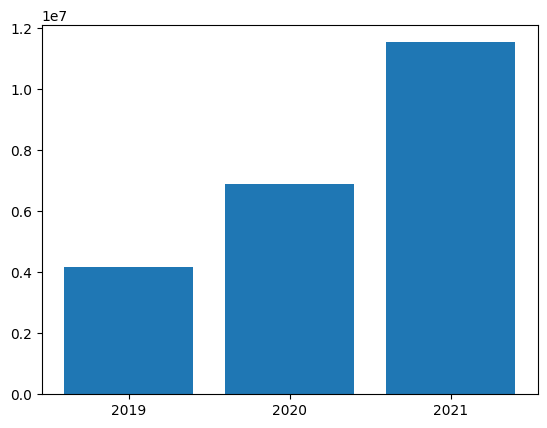

In [0]:
from matplotlib import pyplot as plt
    
# matplotlib requires a Pandas dataframe, not a Spark one
df_sales = df_spark.toPandas()
# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'])
# Display the plot
plt.show()

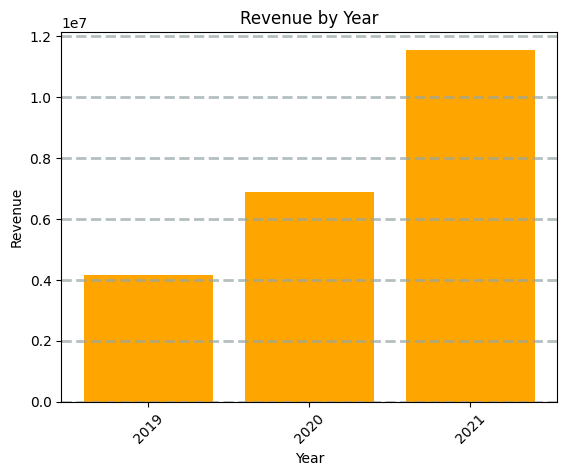

In [0]:
# Clear the plot area
plt.clf()
# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)
# Show the figure
plt.show()

A plot is technically contained with a Figure. In the previous examples, the figure was created implicitly for you; but you can create it explicitly.

<Figure size 640x480 with 0 Axes>

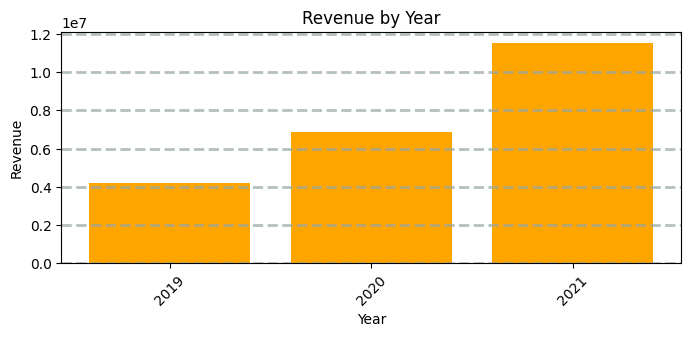

In [0]:
# Clear the plot area
plt.clf()
# Create a Figure
fig = plt.figure(figsize=(8,3))
# Create a bar plot of revenue by year
plt.bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
# Customize the chart
plt.title('Revenue by Year')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)
plt.xticks(rotation=45)
# Show the figure
plt.show()

<Figure size 640x480 with 0 Axes>

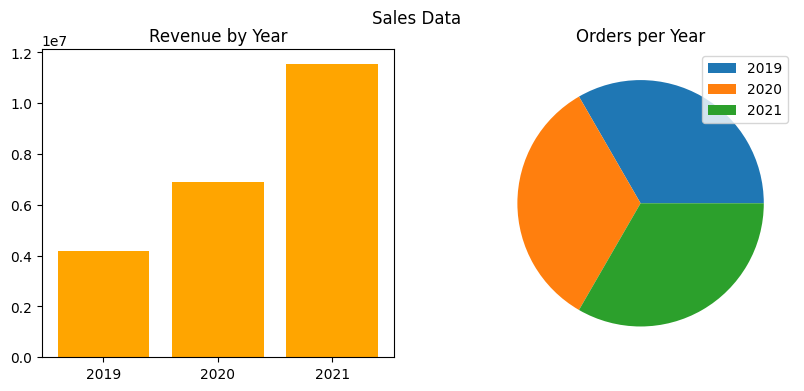

In [0]:
# Clear the plot area
plt.clf()
# Create a figure for 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize = (10,4))
# Create a bar plot of revenue by year on the first axis
ax[0].bar(x=df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')

# Create a pie chart of yearly order counts on the second axis
yearly_counts = df_sales['OrderYear'].value_counts()
ax[1].pie(yearly_counts)
ax[1].set_title('Orders per Year')
ax[1].legend(yearly_counts.keys().tolist())
# Add a title to the Figure
fig.suptitle('Sales Data')
# Show the figure
plt.show()

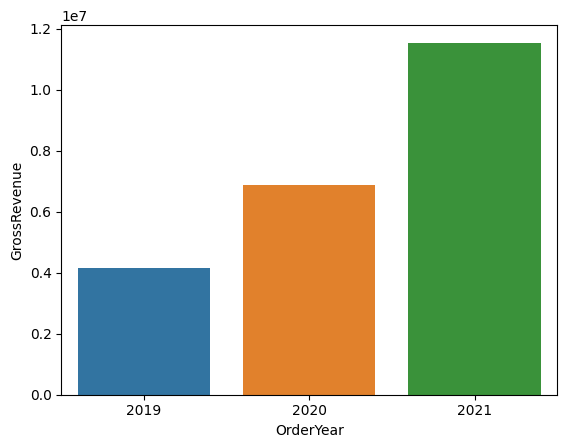

In [0]:
import seaborn as sns
   
# Clear the plot area
plt.clf()
# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

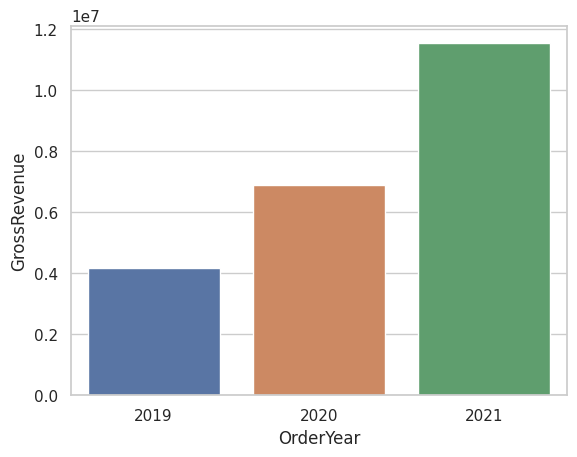

In [0]:
# Clear the plot area
plt.clf()
   
# Set the visual theme for seaborn
sns.set_theme(style="whitegrid")
   
# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

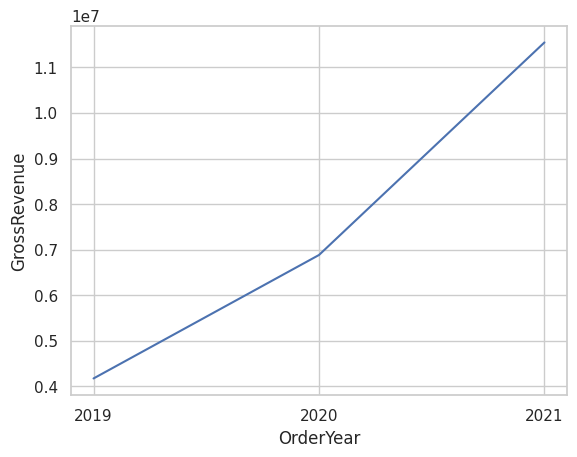

In [0]:
# Clear the plot area
plt.clf()
   
# Create a bar chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()